In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer
import preprocessing
from sklearn.metrics import roc_curve, auc

In [38]:
data_pth = "data/training_data_ht2025.csv"
X_train, X_test, Y_train, Y_test = preprocessing.load_and_split(data_pth)

In [39]:
catboost = CatBoostClassifier(verbose=False)

param_grid = {
    'iterations': [200],
    'learning_rate': [0.01, 0.05],
    'depth': [4, 6]
}

In [40]:
# Stratified K-Fold so that each fold has the same proportion of classes
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=23)

In [41]:
grid_search = GridSearchCV(
    estimator=catboost,
    param_grid=param_grid,
    cv=cv_strategy,
    scoring=make_scorer(f1_score, pos_label=1),
    n_jobs=-1,
    verbose=1
)

In [42]:
print("Grid Search starting...\n")
grid_search.fit(X_train, Y_train)

Grid Search starting...

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=23, shuffle=True),
             estimator=<catboost.core.CatBoostClassifier object at 0x7fd5df11d3a0>,
             n_jobs=-1,
             param_grid={'depth': [4, 6], 'iterations': [200],
                         'learning_rate': [0.01, 0.05]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=1)

In [43]:
print(f"\nBest Parameters found: {grid_search.best_params_}")
print(f"Best Accuracy: {grid_search.best_score_:.4f}")


Best Parameters found: {'depth': 6, 'iterations': 200, 'learning_rate': 0.05}
Best Accuracy: 0.7226


In [44]:
best_rf = grid_search.best_estimator_
y_pred_optimized = best_rf.predict(X_test)

print("Accuracy:", accuracy_score(Y_test, y_pred_optimized))
print(classification_report(Y_test, y_pred_optimized, target_names=['low_bike_demand', 'high_bike_demand']))

Accuracy: 0.884375
                  precision    recall  f1-score   support

 low_bike_demand       0.92      0.94      0.93       262
high_bike_demand       0.71      0.62      0.66        58

        accuracy                           0.88       320
       macro avg       0.81      0.78      0.80       320
    weighted avg       0.88      0.88      0.88       320



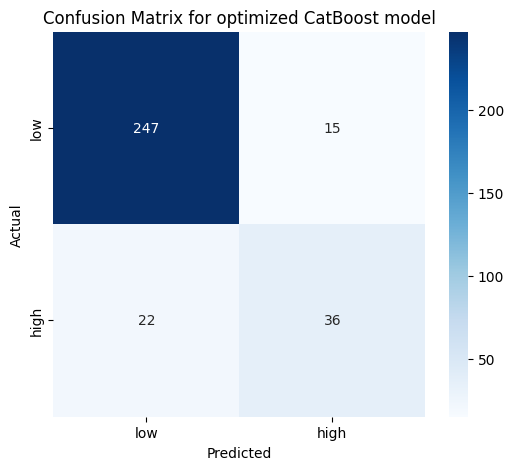

In [45]:
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(Y_test, y_pred_optimized), annot=True, fmt='d', cmap='Blues',
            xticklabels=['low', 'high'], yticklabels=['low', 'high'])
plt.title('Confusion Matrix for optimized CatBoost model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

ROC AUC: 0.9078704922347987


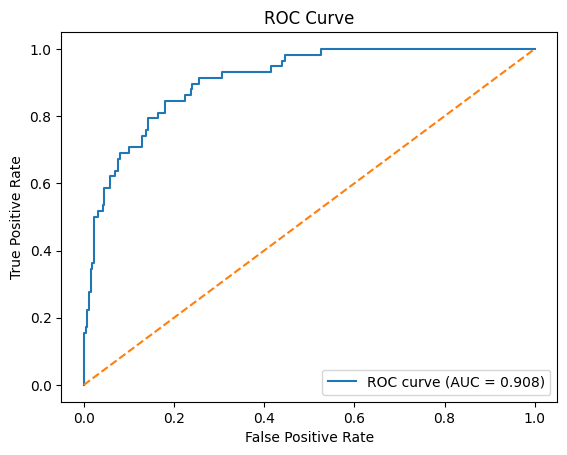

In [55]:
y_pred_proba_optimized = best_rf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba_optimized)

# Compute AUC
roc_auc = auc(fpr, tpr)
print("ROC AUC:", roc_auc)

# Plot
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()